# [A2] Data Preparation and Regression
In this notebook the learned foundations of the **Pandas** library are applied to a **practical example**. 

The aim of this assignment is to first **examine** a dataset using an **Exploratory Data Analysis**. We want to get to know the data and analyze it using an exploratory approach. As part of this process, several methods for **dataset preparation** are introduced.

Second, the preprocessed dataset will be used to train **regression models** that **predict the monthly cold rent** based on various features such as size and condition of the apartment.

## 1: About the Dataset
A user of the data science community Kaggle developed and ran a web-scraper for the biggest **real estate platform** in Germany, **ImmoScout24**.

At three points in time (22th Sept 2018, 10th Mai 2019 and 8th Oct. 2019), all available offers at that time were retrieved from the website and stored. 
In total, data samples of over 200.000 rental properties have been collected.

The data samples contain the most important characteristics of a rental property, such as the size of the living space, the rent, both cold rent and total rent (if applicable), the location (street and house number, if available, zip code and state), energy type, etc. 
There are also two variables that contain longer free text descriptions: Description with text describing what is offered, and Amenities with a description of all available amenities, recent renovation, etc. The date column was added to indicate the time of scraping.

The dataset _immo_data.csv_ can be imported from the 'data' directory or downloaded [from kaggle](https://www.kaggle.com/corrieaar/apartment-rental-offers-in-germany) (account required). An additional file _immo_data_column_description.csv_ contains explanation for each column name.

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

pd.options.display.max_columns = 50

immo = pd.read_csv("data/immo_data.csv.zip")
column_descriptions = pd.read_csv("data/immo_data_column_description.csv")

immo.head(3)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.00,840.00,1965.00,96107057,1.00,oil,False,Nordrhein_Westfalen,True,2.00,595.00,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.00,181.40,1.00,3.00,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8-Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne.,"Die Wohnung ist mit Laminat ausgelegt. Das Badezimmer ist gefliest und verfügt über eine Wannendusche. Neue weiße Zimmertüren, ein Fliesenspiegel in der Küche und Fußleisten wurden kürzlich eingebaut.\nZur Wohnung gehört ein 10 m großer Keller. Eine Garage kann optional mitgemietet werden.",NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.00,NaN,1871.00,111378734,2.00,gas,False,Rheinland_Pfalz,False,1.00,800.00,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.00,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,"Alles neu macht der Mai – so kann es auch für Sie in 2019 sein! Genießen Sie das „reine“ Gefühl und die „Unberührtheit“, die diese Wohnung nach der Kernsanierung bietet.\n\nSie verfügt über eine Wohnfläche von ca. 89 m² und einen äußerst gelungenen Grundriss.\n\nAufgeteilt ist die Wohnung in einen großzügigen Wohn-Essbereich, eine Küche, ein Schlafzimmer, ein Kinder- oder Arbeitszimmer, ein Bad, ein Gäste-WC und einen Flur.\n\nVon der Küche aus haben Sie direkten Zugang zum Balkon, der zum gemütlichen Verweilen und Entspannen einlädt.\n\nDas Badezimmer ist ausgestattet mit Dusche, Toilette, Waschbecken und praktischem Handtuchheizkörper. Zudem gibt es hier jeweils einen Anschluss für die Waschmaschine und für den Trockner.\n\nSämtliche Räume in der Wohnung sind lichtdurchflutet, freundlich und einladend, verstärkt durch die weißen, doppelt verglasten Alufenster und die weißen Wände. \n\nDie Böden sind mit pflegeleichtem Vinyl-Boden und Fliesen ausgelegt und somit auch für Allergiker geeignet.\n\nBeheizt wird die Wohnung mittels einer neuen, energieeffizienten Gas-Etagenheizung der Firma Vaillant. \n\nIm Keller steht allen Mietern ein gemeinschaftlicher Raum zur Verfügung, der für zusätzlichen Stauraum sorgt.\n\nAbgerundet wird dieses tolle Angebot durch 2 Stellplätze, auf dem Sie Ihre Fahrzeuge stets sicher und ohne Parkplatzsuche parken können.\n\n\nWir werden uns bemühen Ihre Anfrage so rasch als möglich zu beantworten, bitte haben Sie jedoch Verständnis, wenn dies 1-2 Werktage in Anspruch nehmen kann!",NaN,NaN,NaN,2019.00,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.00,True,True,8,2.72,2.40,1300.00,2019.00,113147523,1.00,NaN,False,Sachsen,True,9.00,965.00,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.00,NaN,3.00,4.00,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,"Der Neubau entsteht im Herzen der Dresdner Neustadt.\nDas Baugrundstück befindet sich inmitten einer sehr gefragten Lage.\nNicht nur die zentrale Lage und die schnelle öffentliche\nVerkehrsanbindung durch den zu Fuß erreichbaren Bahnhof, wie auch Nahverkehrsanbindung, sondern auch die Architektur werden diesen\nNeubaukomplex zu einem weiteren Highlight am Dresdner Wohnungsmarkt machen.\nHier entstehen 2- bis 4-Raum Wo

As described in the first notebook, some info about the DataFrame and statistical properties of its columns can be automatically generated:

In [68]:
display(immo.info(), immo.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

None

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
count,261941.00,45020.00,268850.00,267018.00,235492.00,228333.00,211805.00,268850.00,93052.00,211805.00,268850.00,268850.00,268850.00,268850.00,268850.00,162344.00,217541.00,171118.00,268850.00,268850.00,85518.00,80711.00,46846.00,46846.00
mean,151.21,10.00,9.79,3.39,28.80,901.33,1966.40,106969670.36,1.33,3.71,694.13,74.36,3.77,37283.02,2.64,114.75,2.12,3.57,2.57,3.07,76.99,2013.90,89.11,0.20
std,308.30,0.00,6.41,1.96,16.34,33238.33,46.99,12500933.41,8.36,2.74,19536.02,254.76,2.21,27798.04,2.63,61.65,3.63,6.38,0.94,1.41,147.72,10.96,5.40,0.01
min,0.00,10.00,0.00,-12.33,1.00,0.00,1000.00,28871743.00,0.00,1.00,0.00,0.00,1.00,852.00,1.00,0.10,-1.00,0.00,1.00,1.00,0.00,1015.00,71.43,0.17
25%,95.00,10.00,6.00,2.00,10.00,469.80,1950.00,106691034.00,1.00,1.00,338.00,54.00,2.00,9128.00,2.00,79.00,1.00,2.00,2.00,2.00,54.00,2012.00,90.76,0.19
50%,135.00,10.00,9.00,3.39,40.00,650.00,1973.00,111158376.00,1.00,3.00,490.00,67.32,3.00,38667.00,3.00,107.00,2.00,3.00,3.00,3.00,70.00,2017.00,90.76,0.20
75%,190.00,10.00,13.00,4.57,40.00,985.00,1996.00,113768759.50,1.00,5.00,799.00,87.00,5.00,57072.00,3.00,140.30,3.00,4.00,3.00,4.00,90.00,2019.00,90.76,0.21
max,146118.00,10.00,121.00,14.92,100.00,15751535.00,2090.00,115711743.00,2241.00,9.00,9999999.00,111111.00,9.00,99998.00,999.99,1996.00,999.00,999.00,5.00,7.00,12613.00,2919.00,90.76,0.23


## 2: First Impressions
At first glance, just by looking at the list of columns, some columns seem to be duplicate.

Besides, we can already identify some columns that are expected to not be helpful for later classification problems. In practice however, you would need to verify this first!

The following code removes these columns. 

In [69]:
immo_2 = immo.drop(["scoutId", "houseNumber", "geo_bln", "geo_krs", "geo_plz", "date"], axis=1)
immo_2.head(3)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.00,840.00,1965.00,1.00,oil,False,True,2.00,595.00,86.00,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,4.00,181.40,1.00,3.00,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8-Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne.,"Die Wohnung ist mit Laminat ausgelegt. Das Badezimmer ist gefliest und verfügt über eine Wannendusche. Neue weiße Zimmertüren, ein Fliesenspiegel in der Küche und Fußleisten wurden kürzlich eingebaut.\nZur Wohnung gehört ein 10 m großer Keller. Eine Garage kann optional mitgemietet werden.",NaN,NaN,NaN,NaN,NaN
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.00,NaN,1871.00,2.00,gas,False,False,1.00,800.00,89.00,refurbished,normal,no,no_information,NaN,False,5,ground_floor,3.00,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,"Alles neu macht der Mai – so kann es auch für Sie in 2019 sein! Genießen Sie das „reine“ Gefühl und die „Unberührtheit“, die diese Wohnung nach der Kernsanierung bietet.\n\nSie verfügt über eine Wohnfläche von ca. 89 m² und einen äußerst gelungenen Grundriss.\n\nAufgeteilt ist die Wohnung in einen großzügigen Wohn-Essbereich, eine Küche, ein Schlafzimmer, ein Kinder- oder Arbeitszimmer, ein Bad, ein Gäste-WC und einen Flur.\n\nVon der Küche aus haben Sie direkten Zugang zum Balkon, der zum gemütlichen Verweilen und Entspannen einlädt.\n\nDas Badezimmer ist ausgestattet mit Dusche, Toilette, Waschbecken und praktischem Handtuchheizkörper. Zudem gibt es hier jeweils einen Anschluss für die Waschmaschine und für den Trockner.\n\nSämtliche Räume in der Wohnung sind lichtdurchflutet, freundlich und einladend, verstärkt durch die weißen, doppelt verglasten Alufenster und die weißen Wände. \n\nDie Böden sind mit pflegeleichtem Vinyl-Boden und Fliesen ausgelegt und somit auch für Allergiker geeignet.\n\nBeheizt wird die Wohnung mittels einer neuen, energieeffizienten Gas-Etagenheizung der Firma Vaillant. \n\nIm Keller steht allen Mietern ein gemeinschaftlicher Raum zur Verfügung, der für zusätzlichen Stauraum sorgt.\n\nAbgerundet wird dieses tolle Angebot durch 2 Stellplätze, auf dem Sie Ihre Fahrzeuge stets sicher und ohne Parkplatzsuche parken können.\n\n\nWir werden uns bemühen Ihre Anfrage so rasch als möglich zu beantworten, bitte haben Sie jedoch Verständnis, wenn dies 1-2 Werktage in Anspruch nehmen kann!",NaN,NaN,NaN,2019.00,NaN,NaN
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.00,True,True,8,2.72,2.40,1300.00,2019.00,1.00,NaN,False,True,9.00,965.00,83.80,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,3.00,NaN,3.00,4.00,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,"Der Neubau entsteht im Herzen der Dresdner Neustadt.\nDas Baugrundstück befindet sich inmitten einer sehr gefragten Lage.\nNicht nur die zentrale Lage und die schnelle öffentliche\nVerkehrsanbindung durch den zu Fuß erreichbaren Bahnhof, wie auch Nahverkehrsanbindung, sondern auch die Architektur werden diesen\nNeubaukomplex zu einem weiteren Highlight am Dresdner Wohnungsmarkt machen.\nHier entstehen 2- bis 4-Raum Wohnungen mit Wohnflächen zwischen 43 m² und 124 m². Jede Wohnung verfügt über eine Terrasse oder einen Balkon, die Erdgeschosswohnungen erhalten zusätzlich einen Gartenanteil. Die Räumlichkeiten bi

### 2.1: ✏️ Characteristics of the Dataset
1.  How large is the (column-reduced) dataset? How many features (columns) or objects (data rows) are available?

In [70]:
# TODO: Implement
print(f'num_cols {len(immo_2.columns)}')
print(f'num_rows {len(immo_2.index)}')

num_cols 43
num_rows 268850


2. Output the first ten objects. Ask yourself: How do they look like? What do you notice? Do you understand the meaning of the features?

In [71]:
# TODO: Implement
immo_2.head(10)

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.00,840.00,1965.00,1.00,oil,False,True,2.00,595.00,86.00,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,4.00,181.40,1.00,3.00,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnung befindet sich in einem gepflegten 8-Familienhaus. Aufgrund der Hanglage bietet sich ein unverbaubarer Blick ins Grüne.,"Die Wohnung ist mit Laminat ausgelegt. Das Badezimmer ist gefliest und verfügt über eine Wannendusche. Neue weiße Zimmertüren, ein Fliesenspiegel in der Küche und Fußleisten wurden kürzlich eingebaut.\nZur Wohnung gehört ein 10 m großer Keller. Eine Garage kann optional mitgemietet werden.",NaN,NaN,NaN,NaN,NaN
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.00,NaN,1871.00,2.00,gas,False,False,1.00,800.00,89.00,refurbished,normal,no,no_information,NaN,False,5,ground_floor,3.00,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,"Alles neu macht der Mai – so kann es auch für Sie in 2019 sein! Genießen Sie das „reine“ Gefühl und die „Unberührtheit“, die diese Wohnung nach der Kernsanierung bietet.\n\nSie verfügt über eine Wohnfläche von ca. 89 m² und einen äußerst gelungenen Grundriss.\n\nAufgeteilt ist die Wohnung in einen großzügigen Wohn-Essbereich, eine Küche, ein Schlafzimmer, ein Kinder- oder Arbeitszimmer, ein Bad, ein Gäste-WC und einen Flur.\n\nVon der Küche aus haben Sie direkten Zugang zum Balkon, der zum gemütlichen Verweilen und Entspannen einlädt.\n\nDas Badezimmer ist ausgestattet mit Dusche, Toilette, Waschbecken und praktischem Handtuchheizkörper. Zudem gibt es hier jeweils einen Anschluss für die Waschmaschine und für den Trockner.\n\nSämtliche Räume in der Wohnung sind lichtdurchflutet, freundlich und einladend, verstärkt durch die weißen, doppelt verglasten Alufenster und die weißen Wände. \n\nDie Böden sind mit pflegeleichtem Vinyl-Boden und Fliesen ausgelegt und somit auch für Allergiker geeignet.\n\nBeheizt wird die Wohnung mittels einer neuen, energieeffizienten Gas-Etagenheizung der Firma Vaillant. \n\nIm Keller steht allen Mietern ein gemeinschaftlicher Raum zur Verfügung, der für zusätzlichen Stauraum sorgt.\n\nAbgerundet wird dieses tolle Angebot durch 2 Stellplätze, auf dem Sie Ihre Fahrzeuge stets sicher und ohne Parkplatzsuche parken können.\n\n\nWir werden uns bemühen Ihre Anfrage so rasch als möglich zu beantworten, bitte haben Sie jedoch Verständnis, wenn dies 1-2 Werktage in Anspruch nehmen kann!",NaN,NaN,NaN,2019.00,NaN,NaN
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.00,True,True,8,2.72,2.40,1300.00,2019.00,1.00,NaN,False,True,9.00,965.00,83.80,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,3.00,NaN,3.00,4.00,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,"Der Neubau entsteht im Herzen der Dresdner Neustadt.\nDas Baugrundstück befindet sich inmitten einer sehr gefragten Lage.\nNicht nur die zentrale Lage und die schnelle öffentliche\nVerkehrsanbindung durch den zu Fuß erreichbaren Bahnhof, wie auch Nahverkehrsanbindung, sondern auch die Architektur werden diesen\nNeubaukomplex zu einem weiteren Highlight am Dresdner Wohnungsmarkt machen.\nHier entstehen 2- bis 4-Raum Wohnungen mit Wohnflächen zwischen 43 m² und 124 m². Jede Wohnung verfügt über eine Terrasse oder einen Balkon, die Erdgeschosswohnungen erhalten zusätzlich einen Gartenanteil. Die Räumlichkeiten bi

3. What are the data types of each feature?

In [72]:
# TODO: Implement
print(immo_2.dtypes)

regio1                       object
serviceCharge               float64
heatingType                  object
telekomTvOffer               object
telekomHybridUploadSpeed    float64
newlyConst                     bool
balcony                        bool
picturecount                  int64
pricetrend                  float64
telekomUploadSpeed          float64
totalRent                   float64
yearConstructed             float64
noParkSpaces                float64
firingTypes                  object
hasKitchen                     bool
cellar                         bool
yearConstructedRange        float64
baseRent                    float64
livingSpace                 float64
condition                    object
interiorQual                 object
petsAllowed                  object
street                       object
streetPlain                  object
lift                           bool
baseRentRange                 int64
typeOfFlat                   object
noRooms                     

4. What are the respective maximum, average and minimum values of the following features?
- telekomUploadSpeed
- livingSpace
- heatingCosts

In [73]:
# TODO: Implement
print(f'telekomUploadSpeed ∈ [{immo_2['telekomUploadSpeed'].min()}, {immo_2['telekomUploadSpeed'].max()}], x̄ = {immo_2["telekomUploadSpeed"].mean()}')
print(f'livingSpace ∈ [{immo_2['livingSpace'].min()}, {immo_2['livingSpace'].max()}], x̄ = {immo_2["livingSpace"].mean()}')
print(f'heatingCosts ∈ [{immo_2['heatingCosts'].min()}, {immo_2['heatingCosts'].max()}], x̄ = {immo_2["heatingCosts"].mean()}')


telekomUploadSpeed ∈ [1.0, 100.0], x̄ = 28.804928405211218
livingSpace ∈ [0.0, 111111.0], x̄ = 74.35554803793936
heatingCosts ∈ [0.0, 12613.0], x̄ = 76.99086578264226


We split the analyzing process into two parts, each regarding either columns of numeric or non-numeric data type. 

## 3: Analyzing Categorical Data
We start with the non-numeric data columns by taking a look at their statistical characteristics: 

In [74]:
immo_2.describe(exclude=np.number).T

,count,unique,top,freq
regio1,268850,16,Nordrhein_Westfalen,62863
heatingType,223994,13,central_heating,128977
telekomTvOffer,236231,3,ONE_YEAR_FREE,227632
newlyConst,268850,2,False,247679
balcony,268850,2,True,165734
firingTypes,211886,132,gas,110899
hasKitchen,268850,2,False,176794
cellar,268850,2,True,172235
condition,200361,10,well_kept,66591
interiorQual,156185,4,normal,81826


The _count_ column shows the number of values in our dataset. If it is lower than our number of data samples, _NaN_ (null) values occur.

The _unique_ columns counts the number of distinct values. 

Those values that are represented the most for each column are mentioned as _top_ in the description table. The _freq_ is this most common value’s frequency.

### 3.1: One Hot Encoding

When categorical features are transformed using One Hot Encoding, a new column is created for each distinct value, as shown in the following example.

This is required for using categorical features in a numeric regression model.

#### 3.1.2: Exemplary One Hot Encoding

In the following cell the column _C2_ of the DataFrame is one-hot encoded, generating new columns that replace the original column _C2_.

In [75]:
example_df = pd.DataFrame({"C1": ["a", "b", "a", "e"], "C2": ["b", "a", "c", "a"]})
example_df_oh = pd.get_dummies(example_df, columns=["C2"])
display(example_df, example_df_oh)

,C1,C2
0,a,b
1,b,a
2,a,c
3,e,a


,C1,C2_a,C2_b,C2_c
0,a,False,True,False
1,b,True,False,False
2,a,False,False,True
3,e,True,False,False


#### 3.1.2: ✏️ Removing Inappropriate Columns for One Hot Encoding
If we would want to one-hot encode the free text feature _description_, we would get a DataFrame with over 200,000 columns - so we exclude attributes with too many values for the time being.

1. In the ``immo_2`` DataFrame, identify the features that could cause too many columns when one-hot encoded and create a DataFrame ``immo_3`` that does not contain these columns

In [76]:
# TODO: Implement
immo_3 = immo_2.drop(columns=['street','streetPlain','regio2','regio3','description','facilities'])
immo_3

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,firingTypes,hasKitchen,cellar,yearConstructedRange,baseRent,livingSpace,condition,interiorQual,petsAllowed,lift,baseRentRange,typeOfFlat,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.00,840.00,1965.00,1.00,oil,False,True,2.00,595.00,86.00,well_kept,normal,NaN,False,4,ground_floor,4.00,181.40,1.00,3.00,4,True,4,NaN,NaN,NaN,NaN,NaN
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.00,NaN,1871.00,2.00,gas,False,False,1.00,800.00,89.00,refurbished,normal,no,False,5,ground_floor,3.00,NaN,NaN,NaN,3,False,4,NaN,NaN,2019.00,NaN,NaN
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.00,True,True,8,2.72,2.40,1300.00,2019.00,1.00,NaN,False,True,9.00,965.00,83.80,first_time_use,sophisticated,NaN,True,6,apartment,3.00,NaN,3.00,4.00,3,False,4,NaN,NaN,NaN,NaN,NaN
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.00,NaN,1964.00,NaN,district_heating,False,False,2.00,343.00,58.15,NaN,NaN,NaN,False,2,other,3.00,86.00,3.00,NaN,3,False,2,87.23,NaN,NaN,NaN,NaN
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.00,1950.00,NaN,gas,False,False,1.00,765.00,84.97,refurbished,NaN,NaN,False,5,apartment,3.00,188.90,1.00,NaN,3,False,4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268845,Bayern,90.00,heat_pump,ONE_YEAR_FREE,NaN,False,True,0,2.74,10.00,910.00,2016.00,1.00,geothermal,False,True,9.00,820.00,90.00,mint_condition,sophisticated,no,False,6,roof_storey,3.00,NaN,NaN,NaN,3,False,4,NaN,NaN,NaN,NaN,NaN
268846,Hessen,220.00,gas_heating,NaN,NaN,False,True,12,6.49,NaN,1150.00,1983.00,1.00,gas,True,False,4.00,930.00,115.00,well_kept,sophisticated,negotiable,False,6,apartment,3.50,NaN,1.00,1.00,3,False,5,NaN,NaN,2015.00,NaN,NaN
268847,Hessen,220.00,central_heating,ONE_YEAR_FREE,NaN,False,True,21,2.90,40.00,930.00,1965.00,1.00,gas,False,True,2.00,650.00,95.00,well_kept,NaN,negotiable,False,5,apartment,4.00,160.77,1.00,2.00,4,True,4,NaN,NaN,2019.00,NaN,NaN
268848,Nordrhein_Westfalen,175.00,heat_pump,NaN,NaN,True,True,16,4.39,NaN,1015.00,2019.00,1.00,gas,False,True,9.00,840.00,70.00,first_time_use,sophisticated,no,True,6,apartment,2.00,24.70,NaN,5.00,2,False,3,40.00,NO_INFORMATION,2019.00,NaN,NaN


2. In the "first impressions" chapter, the zip code was removed. Would you think it has value for predicting the cold rent? What would you need to consider?

In [77]:
# TODO: answer as comment
# the zip code might be useful to have a more clear definition of where the house is located as bigger cities tend to have higher renting prices. As Zip-Codes are not numerical values it would need to be encoded before it can be used as input. Even though zip codes are numbers they have no

3. Take a look at the attribute _firingTypes_. According to the dataset author, it describes the main energy source. In the ``.describe()`` table we saw it has 133 unique values. The similar attribute _heatingType_ has only 13 unique values. Output both lists of unique values to compare the two attributes.

In [78]:
# TODO: Implement
print(immo_2['heatingType'])
print(immo_2['firingTypes'])

0                        central_heating
1         self_contained_central_heating
2                          floor_heating
3                       district_heating
4         self_contained_central_heating
                       ...              
268845                         heat_pump
268846                       gas_heating
268847                   central_heating
268848                         heat_pump
268849                   central_heating
Name: heatingType, Length: 268850, dtype: object
0                      oil
1                      gas
2                      NaN
3         district_heating
4                      gas
                ...       
268845          geothermal
268846                 gas
268847                 gas
268848                 gas
268849    district_heating
Name: firingTypes, Length: 268850, dtype: object


4. We decide to keep the less detailed attribute and keep the dataset simple. What other option do we have? 

In [79]:
# TODO: answer as comment
# instead of one hot encoding we could think about using embedding. We embed the heating feature using firingTypes and heatingType

5. Create a new DataFrame ``immo_4`` without the  _firingTypes_ column.

In [80]:
# TODO: Implement
immo_4 = immo_3.drop(['firingTypes'], axis=1)

### 3.2: Visual Evaluation of Categorical Features
In this section we will take a look at the frequency distribution histograms of all remaining categorical features.

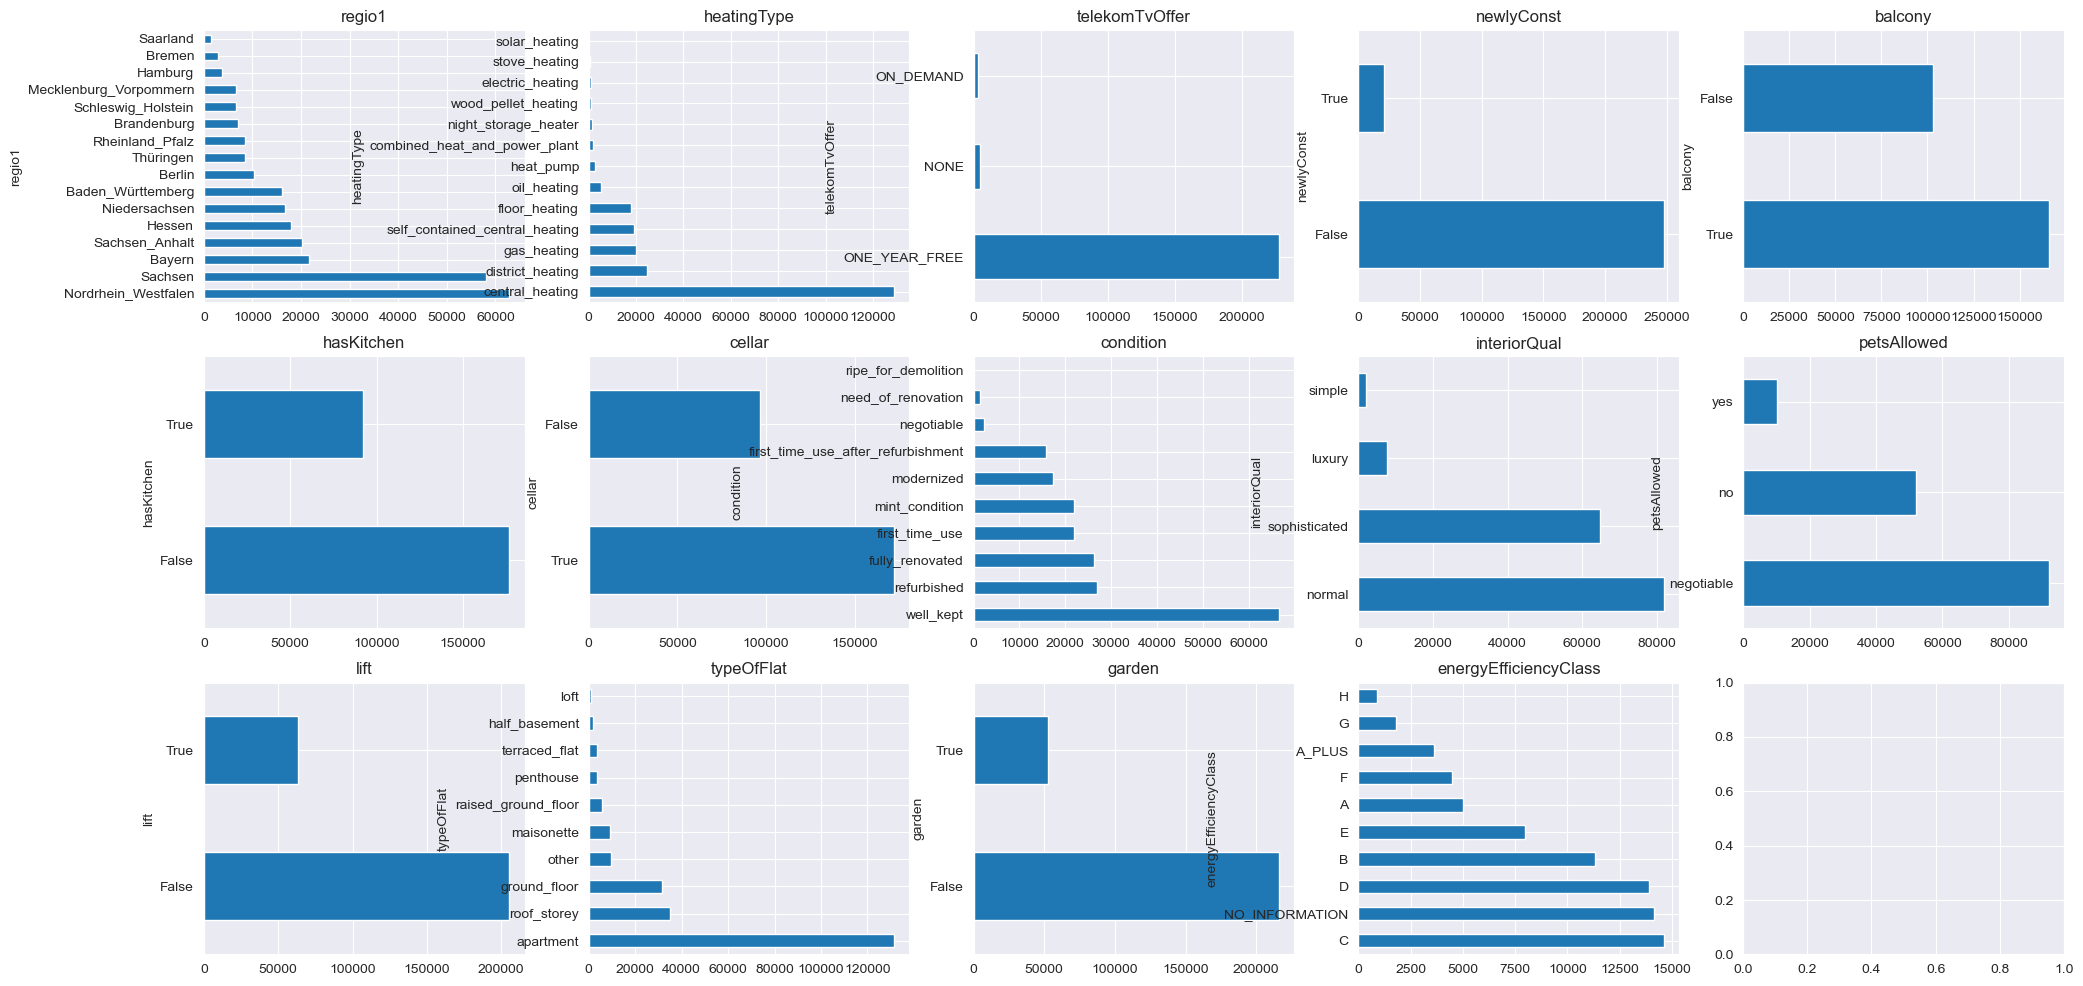

In [81]:
categorical_columns = immo_4.select_dtypes(exclude=np.number).columns

n_cols = 5
n_rows = int(np.ceil(len(categorical_columns) / n_cols))
ax = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)[1].flatten()

for i, colname in enumerate(categorical_columns):
    immo_4[colname].value_counts().plot(kind="barh", ax=ax[i], title=colname, figsize=(24, 12))

plt.show()

One can see that almost all features now contain only a few unique and meaningful values.

Only _regio2_ seems to be too crowded, but that is okay as there still are some values with a lot of occurances.

The one-hot encoding itself will be done in a later chapter to keep the number of columns minimal for now.

## 4: Analyzing Numerical Data
In this section we will take a look at the numeric features. More precisely, we look mainly at outlier detection and handling.

### 4.1: Outliers
An outlier is an observation that lies an abnormal distance from other values in a given set of data. Outliers can negatively impact the quality of a regression model, which is why it is important to identify them and find a solution to deal with them.

#### 4.1.1: ✏️ Outlier Detection
Outliers can be spotted visually, e.g. when looking at a histogram or statistically by reviewing the characteristics of each column.
First, we will use the ``.describe()`` method again.

In [82]:
# reduce the number of decimals shown in the output (for better readability)
pd.set_option("display.float_format", lambda x: f"{x:.2f}")

immo_4.describe(include=np.number).drop("count").T

,mean,std,min,25%,50%,75%,max
serviceCharge,151.21,308.30,0.00,95.00,135.00,190.00,146118.00
telekomHybridUploadSpeed,10.00,0.00,10.00,10.00,10.00,10.00,10.00
picturecount,9.79,6.41,0.00,6.00,9.00,13.00,121.00
pricetrend,3.39,1.96,-12.33,2.00,3.39,4.57,14.92
telekomUploadSpeed,28.80,16.34,1.00,10.00,40.00,40.00,100.00
totalRent,901.33,33238.33,0.00,469.80,650.00,985.00,15751535.00
yearConstructed,1966.40,46.99,1000.00,1950.00,1973.00,1996.00,2090.00
noParkSpaces,1.33,8.36,0.00,1.00,1.00,1.00,2241.00
yearConstructedRange,3.71,2.74,1.00,1.00,3.00,5.00,9.00
baseRent,694.13,19536.02,0.00,338.00,490.00,799.00,9999999.00


1. Take a look at the table to see if you can find some of the extreme outliers in the data by yourself.


In [83]:
# TODO: Answer
# totalRent, heatingCosts, baseRent, serviceCharge, yearConstructed, noParkSpaces, numberOfFloors, floor, lastRefurbished


We save the names of all these suspicious columns in a list to further inspect them.
Furthermore, we see that the feature _telekomHybridUploadSpeed_ always has the value 10 or is empty, so we delete it.

In [84]:
interesting_columns = [
    "serviceCharge",
    "totalRent",
    "yearConstructed",
    "noParkSpaces",
    "baseRent",
    "livingSpace",
    "noRooms",
    "numberOfFloors",
    "heatingCosts",
    "lastRefurbish",
]

immo_5 = immo_4.drop(["telekomHybridUploadSpeed"], axis=1)

#### 4.1.2: ✏️ Outlier Visualization
Outliers can be visualized using histograms and boxplot charts.

1. Adapt the visualization code used for categorical data to show histograms of *all* the numerical columns (instead of using ``value_counts()``)

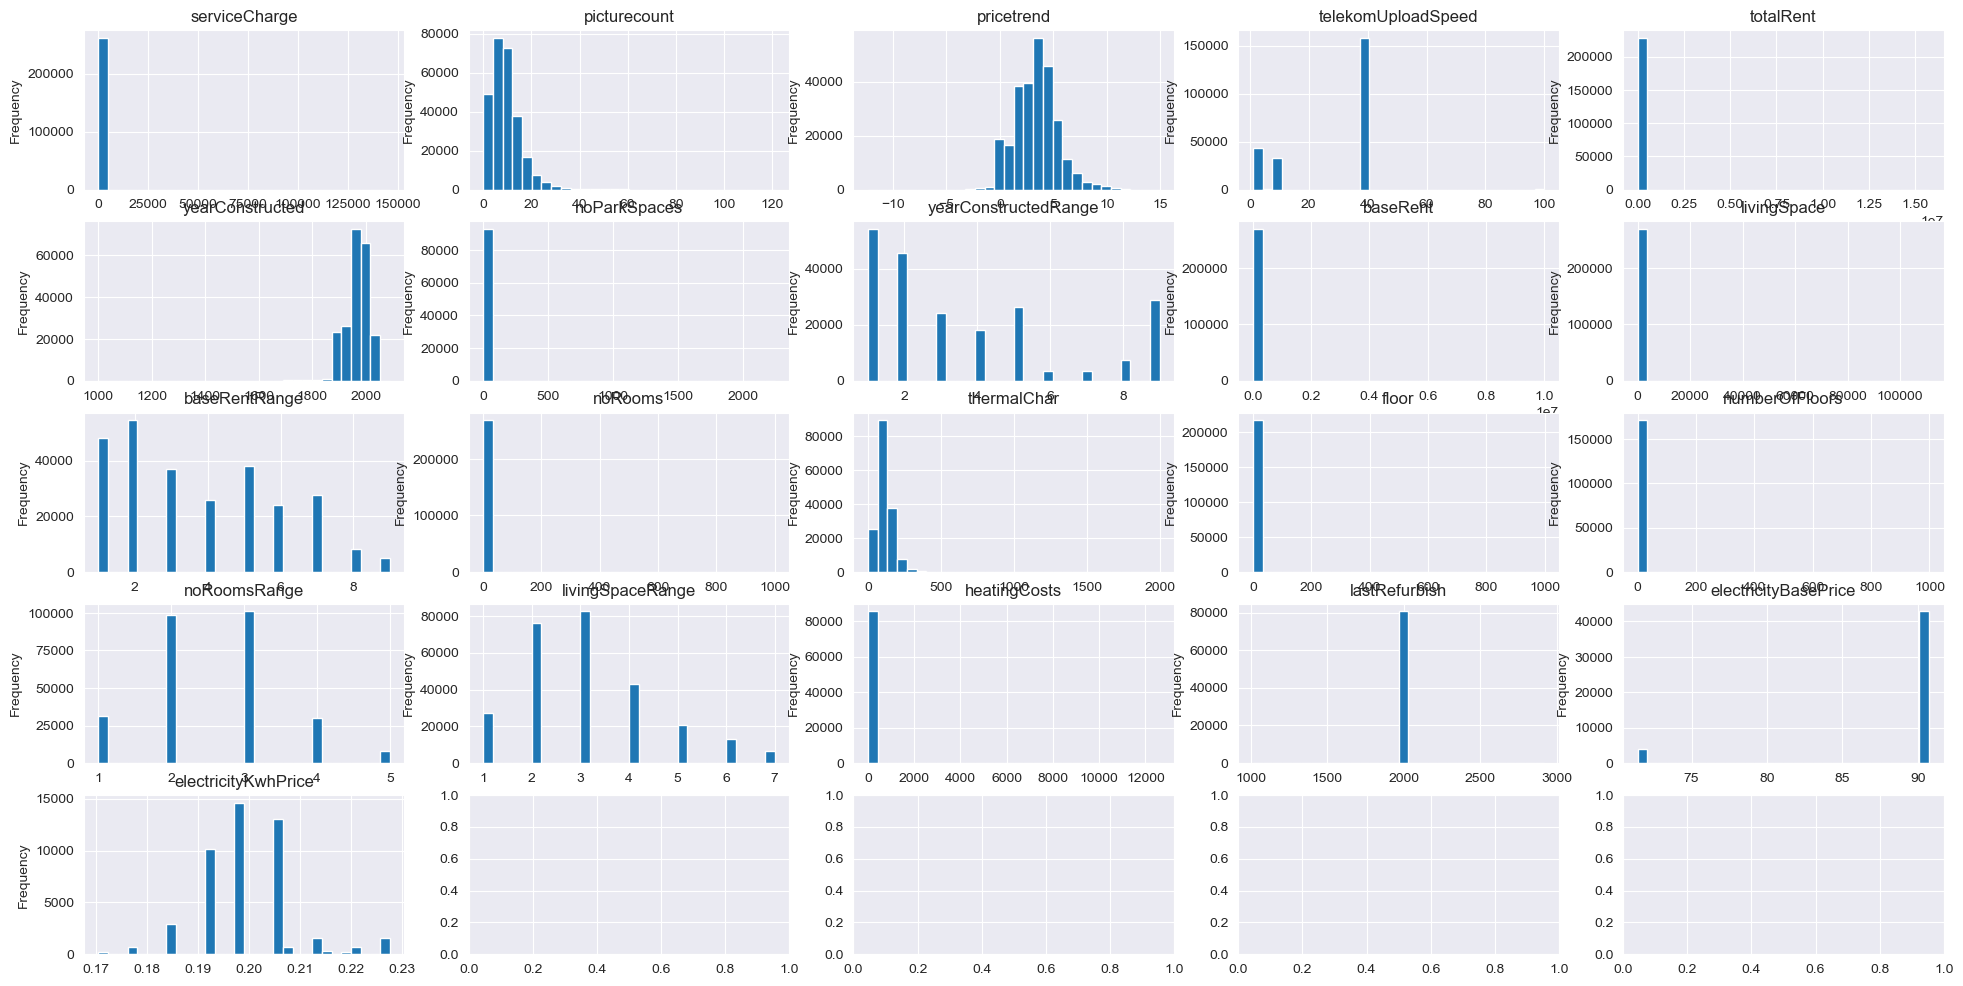

In [85]:
# TODO: Implement
numeric_columns = immo_5.select_dtypes(include=np.number).columns

n_cols = 5
n_rows = int(np.ceil(len(numeric_columns) / n_cols))
ax = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)[1].flatten()

for i, colname in enumerate(numeric_columns):
    immo_5[colname].plot(kind="hist", ax=ax[i], title=colname, figsize=(24, 12), bins=30)

plt.show()


2. Adapt the visualization code to show box plots of *only the interesting* numerical columns 

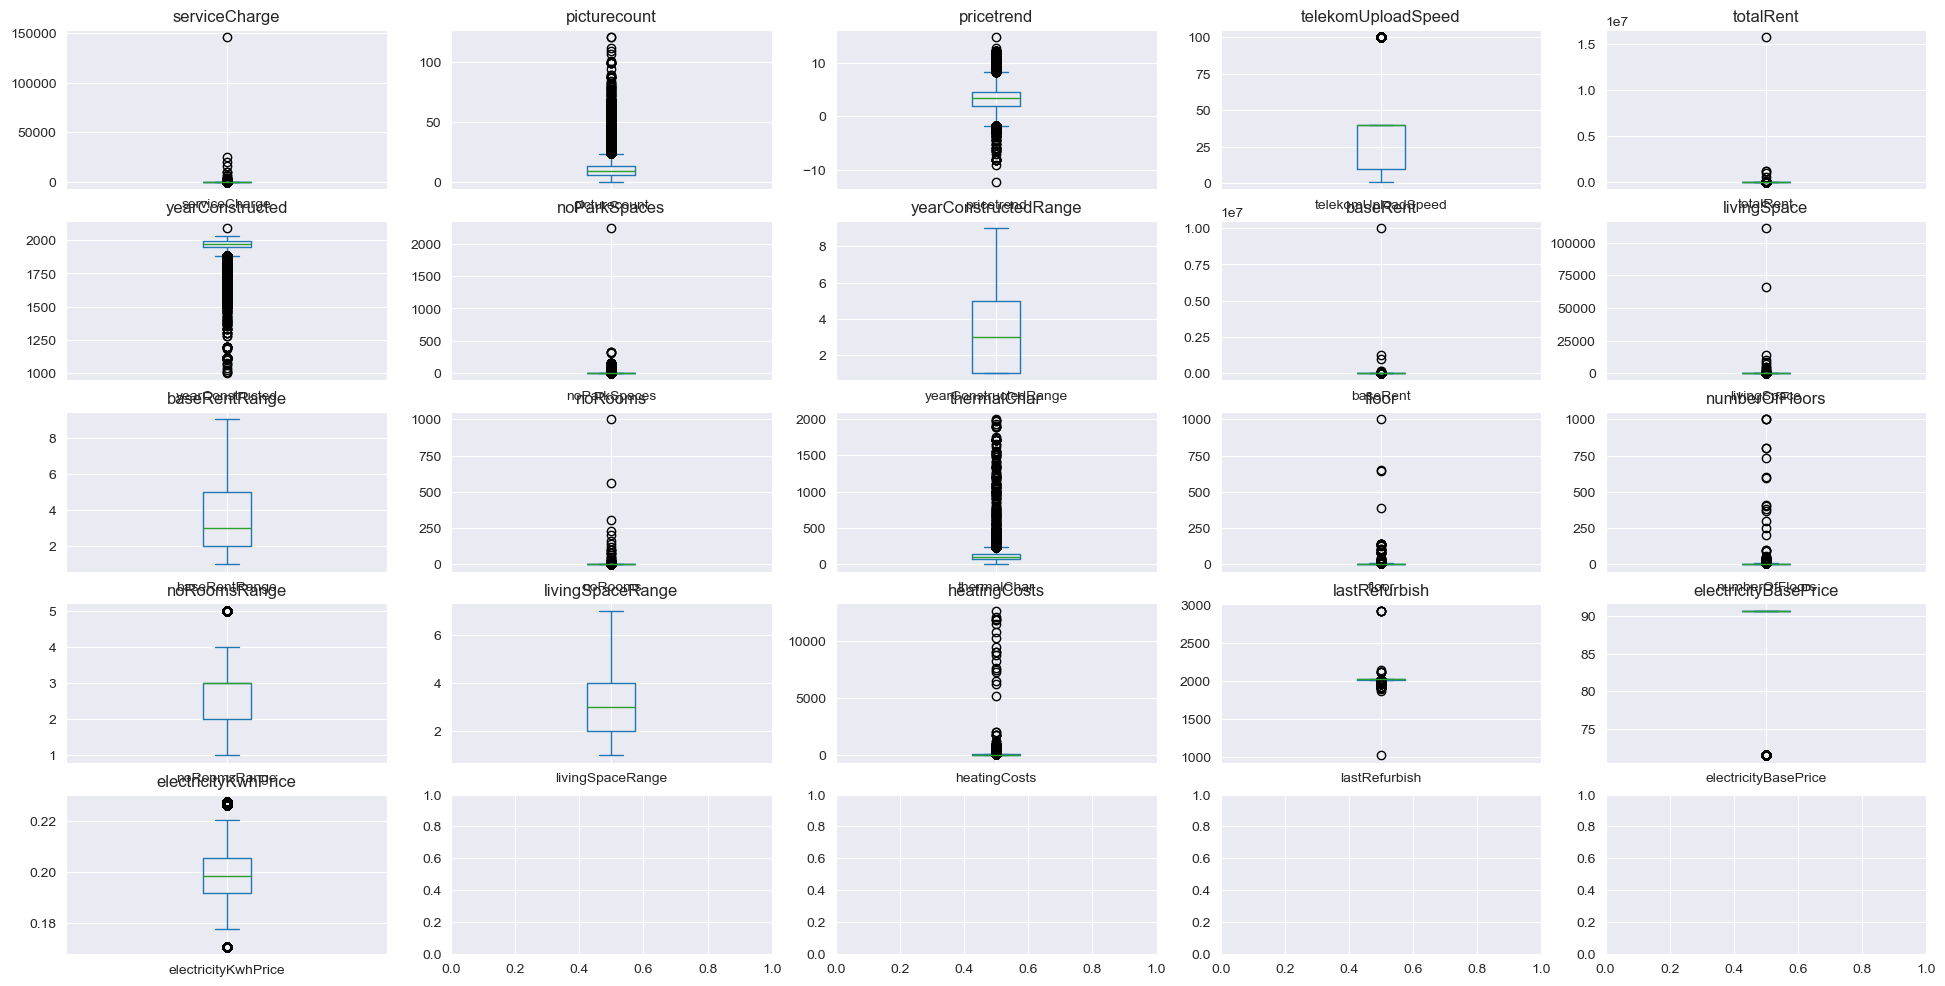

In [86]:
# TODO: Implement
numeric_columns = immo_5.select_dtypes(include=np.number).columns

n_cols = 5
n_rows = int(np.ceil(len(numeric_columns) / n_cols))
ax = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)[1].flatten()

for i, colname in enumerate(numeric_columns):
    immo_5[colname].plot(kind="box", ax=ax[i], title=colname, figsize=(24, 12))

plt.show()

#### 4.1.3: Outlier Removal
Looking at the plots, we decide that these are too many outliers to adress them individually in this excercise.

Instead, we take look at what would happen if we would simply cut off the top and bottom 0.5% of the data.

In [87]:
upper_limits  = immo_5[interesting_columns].quantile(0.005)
lower_limits = immo_5[interesting_columns].quantile(0.995)

limits = pd.DataFrame({"lower bound": upper_limits, "upper bound": lower_limits})
limits


,lower bound,upper bound
serviceCharge,0.00,500.00
totalRent,220.00,3473.48
yearConstructed,1810.02,2020.00
noParkSpaces,0.00,16.00
baseRent,152.00,3000.00
livingSpace,18.00,208.00
noRooms,1.00,6.00
numberOfFloors,0.00,14.00
heatingCosts,0.00,233.00
lastRefurbish,1990.00,2020.00


This looks like a healthier distribution. 
We therefore create a new DataFrame containing only the rows that fit within these bounds (plus those that are _NaN_, these we will care about later):

In [88]:
immo_6 = immo_5.copy()

for colname, (lower, upper) in limits.iterrows():
    col = immo_5[colname]
    # immo_6[colname].loc[:] = np.nan
    immo_6[colname] = immo_5[((col <= upper) & (col >= lower)) | col.isna()][colname]

We can compare the statistical characteristics and number of _NaN_ cells before and after the conversion to check if everything worked as intended:

In [89]:
nans_5 = immo_5.select_dtypes(include=np.number).isna().sum().rename("count_NaN")
nans_6 = immo_6.select_dtypes(include=np.number).isna().sum().rename("count_NaN")
desc_5 = immo_5.describe(include=np.number).drop("count").T.join(nans_5)
desc_6 = immo_6.describe(include=np.number).drop("count").T.join(nans_6)

pd.concat([desc_5, desc_6, desc_6 - desc_5], axis=1, keys=["immo_5", "immo_6", "Δ"])

immo_5                                           \
                        mean      std     min     25%     50%     75%   
serviceCharge         151.21   308.30    0.00   95.00  135.00  190.00   
picturecount            9.79     6.41    0.00    6.00    9.00   13.00   
pricetrend              3.39     1.96  -12.33    2.00    3.39    4.57   
telekomUploadSpeed     28.80    16.34    1.00   10.00   40.00   40.00   
totalRent             901.33 33238.33    0.00  469.80  650.00  985.00   
yearConstructed      1966.40    46.99 1000.00 1950.00 1973.00 1996.00   
noParkSpaces            1.33     8.36    0.00    1.00    1.00    1.00   
yearConstructedRange    3.71     2.74    1.00    1.00    3.00    5.00   
baseRent              694.13 19536.02    0.00  338.00  490.00  799.00   
livingSpace            74.36   254.76    0.00   54.00   67.32   87.00   
baseRentRange           3.77     2.21    1.00    2.00    3.00    5.00   
noRooms                 2.64     2.63    1.00    2.00    3.00    3.00   
thermalChar           114.75    61.65    0.10   79.00  107.00  140.30   
floor                   2.12     3.63   -1.00    1.00    2.00    3.00   
numberOfFloors          3.57     6.38    0.00    2.00    3.00    4.00   
noRoomsRange            2.57     0.94    1.00    2.00    3.00    3.00   
livingSpaceRange        3.07     1.41    1.00    2.00    3.00    4.00   
heatingCosts           76.99   147.72    0.00   54.00   70.00   90.00   
lastRefurbish        2013.90    10.96 1015.00 2012.00 2017.00 2019.00   
electricityBasePrice   89.11     5.40   71.43   90.76   90.76   90.76   
electricityKwhPrice     0.20     0.01    0.17    0.19    0.20    0.21   

                                            immo_6                         \
                             max count_NaN    mean    std     min     25%   
serviceCharge          146118.00      6909  147.55  76.81    0.00   95.00   
picturecount              121.00         0    9.79   6.41    0.00    6.00   
pricetrend                 14.92      1832    3.39   1.96  -12.33    2.00   
telekomUploadSpeed        100.00     33358   28.80  16.34    1.00   10.00   
totalRent            15751535.00     40517  797.35 473.25  220.00  470.00   
yearConstructed          2090.00     57045 1968.03  38.41 1811.00 1950.00   
noParkSpaces             2241.00    175798    1.10   0.71    0.00    1.00   
yearConstructedRange        9.00     57045    3.71   2.74    1.00    1.00   
baseRent              9999999.00         0  632.11 423.84  152.00  340.00   
livingSpace            111111.00         0   72.89  29.10   18.00   54.24   
baseRentRange               9.00         0    3.77   2.21    1.00    2.00   
noRooms                   999.99         0    2.62   0.95    1.00    2.00   
thermalChar              1996.00    106506  114.75  61.65    0.10   79.00   
floor                     999.00     51309    2.12   3.63   -1.00    1.00   
numberOfFloors            999.00     97732    3.45   1.65    0.00    2.00   
noRoomsRange                5.00         0    2.57   0.94    1.00    2.00   
livingSpaceRange            7.00         0    3.07   1.41    1.00    2.00   
heatingCosts            12613.00    183332   73.61  33.01    0.00   54.00   
lastRefurbish            2919.00    188139 2014.00   7.03 1990.00 2013.00   
electricityBasePrice       90.76    222004   89.11   5.40   71.43   90.76   
electricityKwhPrice         0.23    222004    0.20   0.01    0.17    0.19   

                                                             Δ            \
                         50%     75%     max count_NaN    mean       std   
serviceCharge         135.00  187.00  500.00      8208   -3.66   -231.49   
picturecount            9.00   13.00  121.00         0    0.00      0.00   
pricetrend              3.39    4.57   14.92      1832    0.00      0.00   
telekomUploadSpeed     40.00   40.00  100.00     33358    0.00      0.00   
totalRent             650.00  980.00 3472.70     42739 -103.98 -32765.08   
yearConstructed      1973.00 1996.00 2

We see that the minimum and maximum values look far more reasonable now. However, the number of _NaN_ fields has increased, as our conversion simply replaced all outlier values with _NaN_.

If this is a valid approach depends very much on your task and often times it would make more sense to instead drop all outlier rows. 

At the very latest, it is now time to take care of the NaN values.

## 5: Handling Missing Values
Let's take a look at how many missing values we have for both kind of data types:


In [90]:
nans = immo_6.isna().sum().rename("count_NaN").sort_values(ascending=False)
dtypes = immo_6.dtypes.rename("dtype")
display(nans.to_frame().join(dtypes))
print("Total Number of NaNs:", immo_6.isna().sum().sum())

,count_NaN,dtype
electricityKwhPrice,222004,float64
electricityBasePrice,222004,float64
energyEfficiencyClass,191063,object
lastRefurbish,188462,float64
heatingCosts,183758,float64
noParkSpaces,176253,float64
petsAllowed,114573,object
interiorQual,112665,object
thermalChar,106506,float64
numberOfFloors,98486,float64


Total Number of NaNs: 2056964


Some of these columns contain many _NaN_ values, if we ignored all these, there would not be many rows left. 

We therefore follow this strategy first: 

- For numeric values, the mean of the remaining values is used for a missing value.

- For non-numeric values, the most frequent value (=mode) of the remaining values is used for a missing value.

This is a very simple approach, but it obviously will alter the true distribution of our data.

### 5.1 ✏️ Replacing Missing Values
To fill _NaN_ values, pandas provides the ``.fillna()`` method. It simply replaces all _NaNs_ with a certain value.

The machine learning library **scikit-learn** provides a more advanced interface, the [_SimpleImputer_](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html).
In contrast, it can replace missing values using a descriptive statistic like mean, median, or the most frequent value along each column.

1. Create a _SimpleImputer_ object to replace all _NaN_ values in numerical columns with the mean of the respective column. Apply it to _immo_7_ and replace the respective columns with the new data. Finally, print the total number of NaNs in the new dataframe.

In [91]:
immo_7 = immo_6.copy()

numeric_columns = immo_7.select_dtypes(include=np.number).columns

# TODO: Implement
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
immo_7.loc[:,numeric_columns] = imp_mean.fit_transform(immo_7[numeric_columns])
print("Total Number of NaNs:", immo_7.isna().sum().sum())

Total Number of NaNs: 600879


2. Create a new DataFrame _immo_8_ in which _NaN_ values in all non-numeric columns are replaced with the most frequent value of that column. Again, print the number of NaNs in the new DataFramne (should be 0).  

In [92]:
immo_8 = immo_7.copy()

imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
categorical_columns = immo_8.select_dtypes(exclude=np.number).columns
immo_8.loc[:,categorical_columns] = imp_freq.fit_transform(immo_8[categorical_columns])

print("Total Number of NaNs:", immo_8.isna().sum().sum())

Total Number of NaNs: 0


## 6: Feature Engineering
In general, feature engineering is the process of transforming raw data to meaningful features that can be used for machine learning.

So far, we have cleaned the raw data to make it easier to decide which features to create.

Typical engineered features include[¹](https://en.wikipedia.org/wiki/Feature_engineering):

- for numerical data
    - Numerical transformations (like taking fractions or scaling)
    - Clustering
    - Group aggregated values
    - Principal component analysis
    - Constructed metrics based on proven scientific research in the specific domain.
- for categorical data
    - Encoded Category encoder (like one-hot or target encoding)

### 6.1: Analyzing Correlations
We generate scatter plots to identify obvious linear or nonlinear relationships between individual features and the target variable *baseRent*.

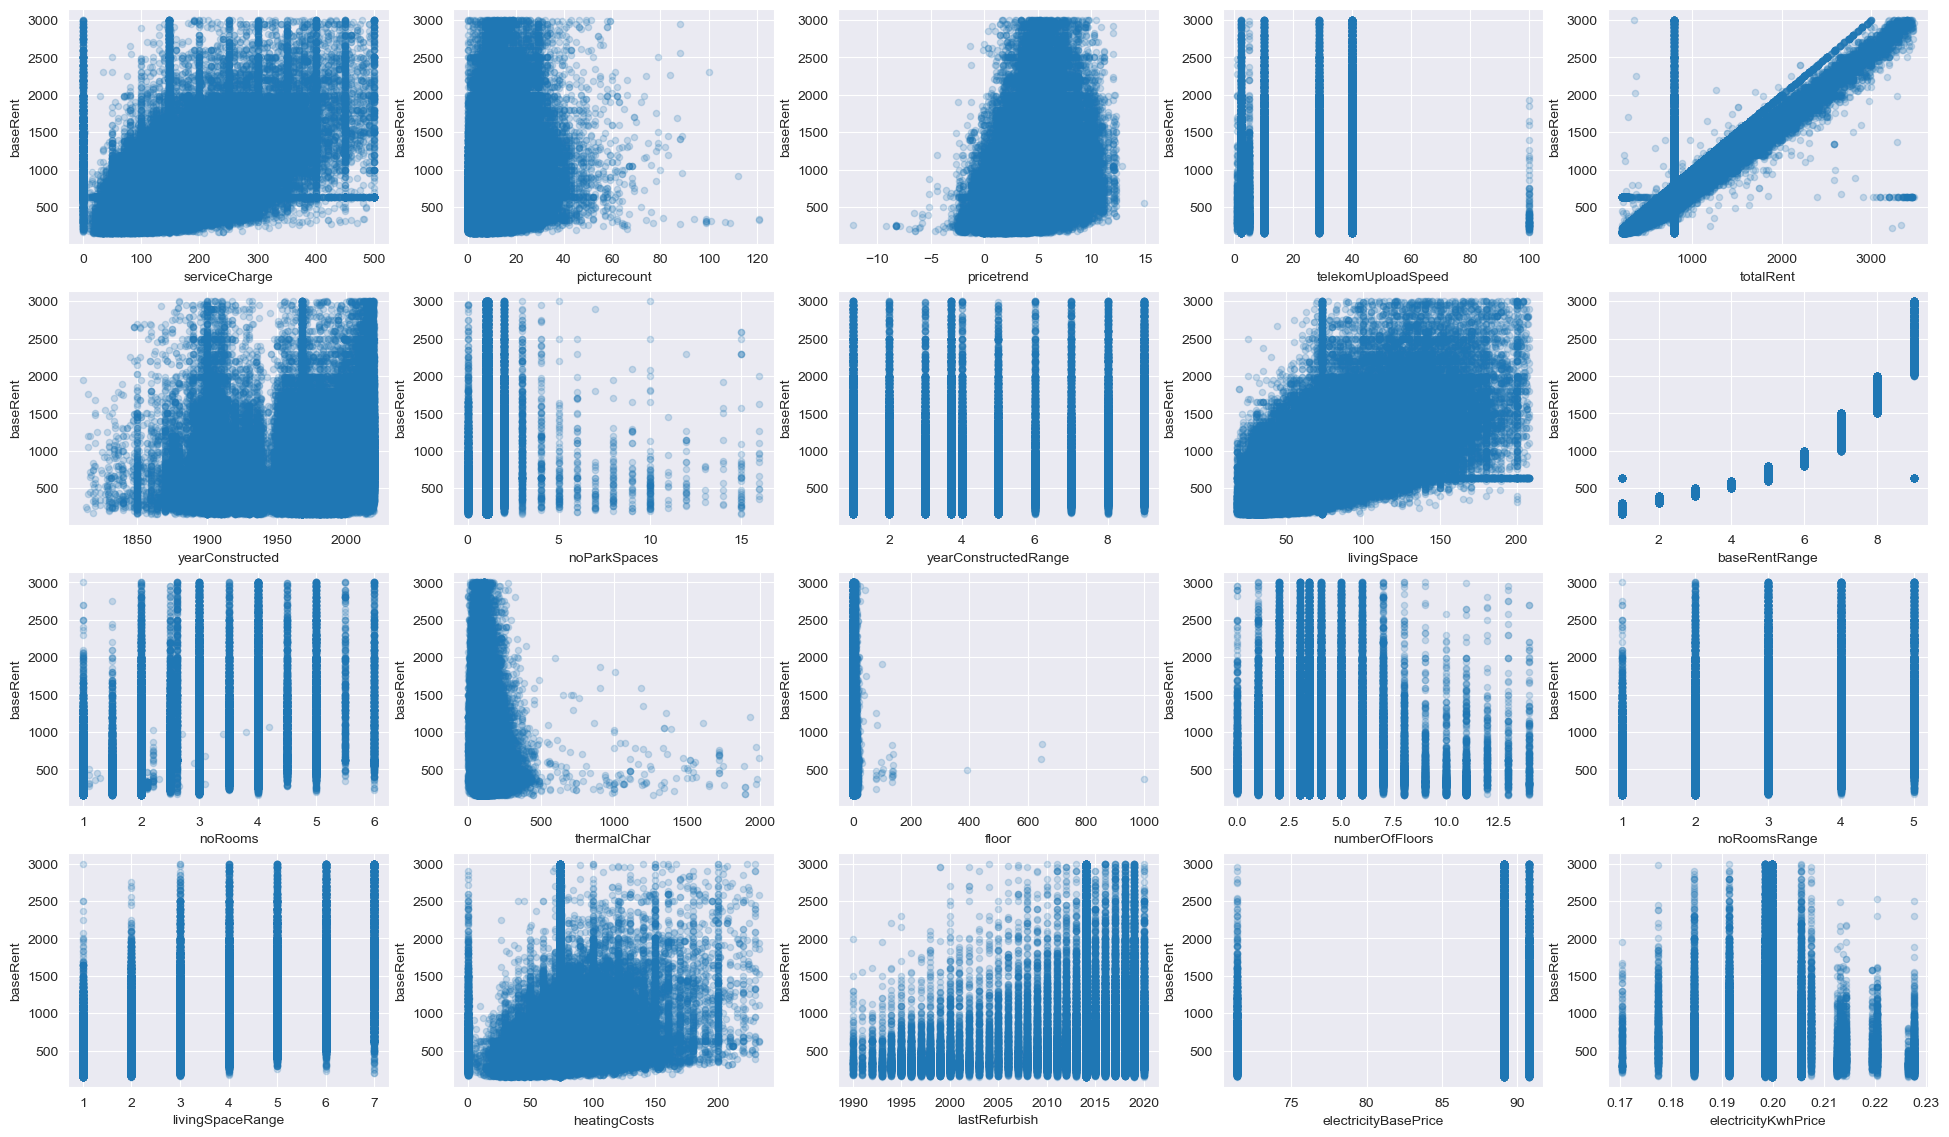

In [93]:
numeric_columns = list(immo_8.select_dtypes(include=np.number).columns)
numeric_columns.remove("baseRent")

n_cols = 5
n_rows = int(np.ceil(len(numeric_columns) / n_cols))
ax = plt.subplots(nrows=n_rows, ncols=n_cols, squeeze=False)[1].flatten()

for i, colname in enumerate(numeric_columns):
    immo_8[["baseRent",colname]].plot.scatter(x=colname, y="baseRent", ax=ax[i], figsize=(24, 14), alpha=0.2)

plt.show()

✏️ Take a moment to understand the graph. Which correlations do you notice?

➡️ The data scatters relatively broadly. As expected, there is correlation between size and rental price.
Of course, there also is a correlation between the target feature and closely related features like _baseRent_ - we will handle this in the next chapter. 
For now, we see no further anomalies.

We can also plot the correlation coefficient for all combinations of features (= a correlation matrix) to see which features are similar to each other.
For this, we use the **seaborn** library that acts as a wrapper for commonly used matplotlib plots.

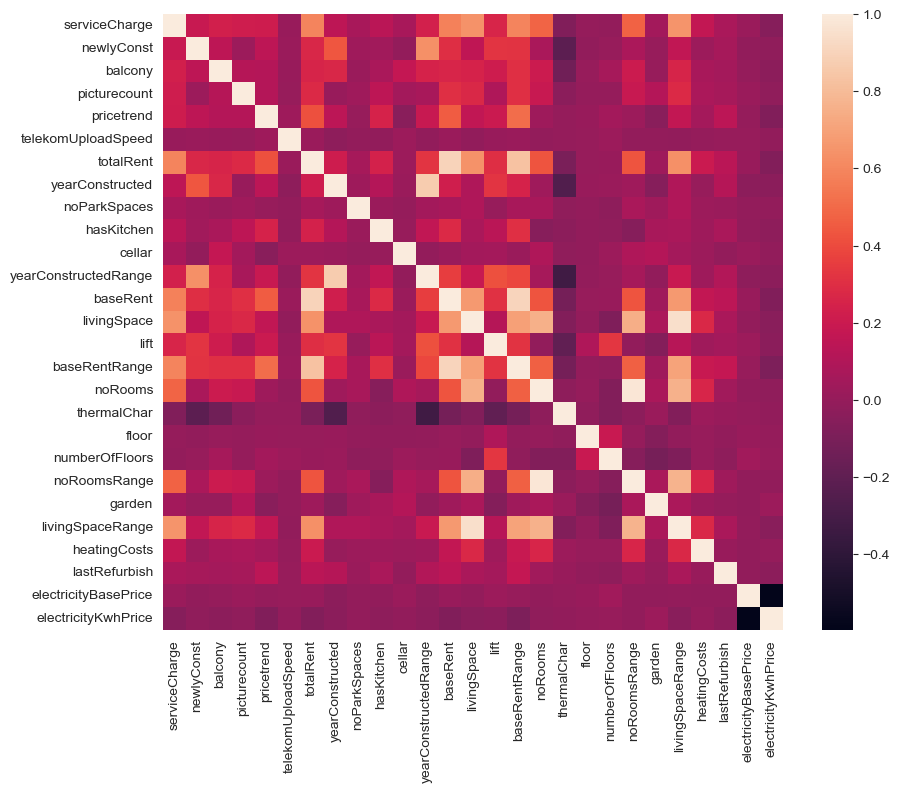

In [94]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(immo_8.corr(numeric_only=True))
plt.show()

Other than the already noted correlations to _baseRent_, we only see new correlations in between features and their corresponding _range_ features (e.g. _noRooms_ and _noRoomsRange_). That is acceptable and we will continue without further action.

In this example, we will not create any new features other than the one hot encoding.

### 6.2 ✏️ Applying the One Hot Encoding
Next, we transform the categorical columns using OneHot encoding. 

1. Apply the code mentioned in the One Hot Encoding example from earlier to encode the categorical columns of our DataFrame.

In [95]:
immo_9 = immo_8.copy()

# TODO: Implement
categorical_columns = immo_9.select_dtypes(exclude=np.number).columns
numerical_columns = immo_9.select_dtypes(include=np.number).columns
one_hot = pd.get_dummies(immo_9[categorical_columns])
immo_9 = one_hot.merge(immo_9[numerical_columns], left_index=True, right_index=True)
immo_9.head(1)

,newlyConst,balcony,hasKitchen,cellar,lift,garden,regio1_Baden_Württemberg,regio1_Bayern,regio1_Berlin,regio1_Brandenburg,regio1_Bremen,regio1_Hamburg,regio1_Hessen,regio1_Mecklenburg_Vorpommern,regio1_Niedersachsen,regio1_Nordrhein_Westfalen,regio1_Rheinland_Pfalz,regio1_Saarland,regio1_Sachsen,regio1_Sachsen_Anhalt,regio1_Schleswig_Holstein,regio1_Thüringen,heatingType_central_heating,heatingType_combined_heat_and_power_plant,heatingType_district_heating,...,energyEfficiencyClass_F,energyEfficiencyClass_G,energyEfficiencyClass_H,energyEfficiencyClass_NO_INFORMATION,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,245.00,6,4.62,10.00,840.00,1965.00,1.00,2.00,595.00,86.00,4,4.00,181.40,1.00,3.00,4,4,73.61,2014.00,89.11,0.20


Let's take a look at the created DataFrame:

In [96]:
print("Shape:", immo_9.shape, ", Columns:", list(immo_9.columns))
immo_9.head(2)

Shape: (268850, 96) , Columns: ['newlyConst', 'balcony', 'hasKitchen', 'cellar', 'lift', 'garden', 'regio1_Baden_Württemberg', 'regio1_Bayern', 'regio1_Berlin', 'regio1_Brandenburg', 'regio1_Bremen', 'regio1_Hamburg', 'regio1_Hessen', 'regio1_Mecklenburg_Vorpommern', 'regio1_Niedersachsen', 'regio1_Nordrhein_Westfalen', 'regio1_Rheinland_Pfalz', 'regio1_Saarland', 'regio1_Sachsen', 'regio1_Sachsen_Anhalt', 'regio1_Schleswig_Holstein', 'regio1_Thüringen', 'heatingType_central_heating', 'heatingType_combined_heat_and_power_plant', 'heatingType_district_heating', 'heatingType_electric_heating', 'heatingType_floor_heating', 'heatingType_gas_heating', 'heatingType_heat_pump', 'heatingType_night_storage_heater', 'heatingType_oil_heating', 'heatingType_self_contained_central_heating', 'heatingType_solar_heating', 'heatingType_stove_heating', 'heatingType_wood_pellet_heating', 'telekomTvOffer_NONE', 'telekomTvOffer_ONE_YEAR_FREE', 'telekomTvOffer_ON_DEMAND', 'condition_first_time_use', 'condit

,newlyConst,balcony,hasKitchen,cellar,lift,garden,regio1_Baden_Württemberg,regio1_Bayern,regio1_Berlin,regio1_Brandenburg,regio1_Bremen,regio1_Hamburg,regio1_Hessen,regio1_Mecklenburg_Vorpommern,regio1_Niedersachsen,regio1_Nordrhein_Westfalen,regio1_Rheinland_Pfalz,regio1_Saarland,regio1_Sachsen,regio1_Sachsen_Anhalt,regio1_Schleswig_Holstein,regio1_Thüringen,heatingType_central_heating,heatingType_combined_heat_and_power_plant,heatingType_district_heating,...,energyEfficiencyClass_F,energyEfficiencyClass_G,energyEfficiencyClass_H,energyEfficiencyClass_NO_INFORMATION,serviceCharge,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice
0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,245.00,6,4.62,10.00,840.00,1965.00,1.00,2.00,595.00,86.00,4,4.00,181.40,1.00,3.00,4,4,73.61,2014.00,89.11,0.20
1,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,134.00,8,3.47,10.00,797.35,1871.00,2.00,1.00,800.00,89.00,5,3.00,114.75,2.12,3.45,3,4,73.61,2019.00,89.11,0.20


Altogether, we now have a data matrix with 268850 records (rows) and 515 features (columns).

## 7: Handling the Target Column
Finally, we will need to extract the target column and remove all columns that might lead the algorithm to overfit because of the high correlation.

Keeping these "easy" columns in the dataset would almost be cheating ;)

Furthermore, it makes sense to remove all rows that do not contain a value for the target column.

In [97]:
immo_X = immo_9[immo_9["baseRent"].isna() == False]

immo_Y = immo_X["baseRent"]
immo_X = immo_X.drop(["baseRent", "totalRent", "baseRentRange"], axis=1)
print(immo_Y.shape, immo_X.shape)

(268850,) (268850, 93)


In a real world example, you might want to export your final DataFrame now, e.g. to a new csv file.

````python
immo_X.to_csv('immoscout_prepared_X.csv', index=False)
````

To keep state consistent between students, we will however not build upon this file now but instead rely on the methods introduced in the following chapter.

## 8: Summary of Data Preparation
In production, the steps to import and explore the dataset can be summarized in a small number of functions. 

The goal of this section is to once again read the dataset file and perform only the core preparation steps we identified so far:
- delete irrelevant and target-related columns
- delete outliers
- impute NaN values
- one-hot encode categorical features
- remove rows without label
- extract target column

We define re-usable methods (for this specific dataset) and then call them subsequently.

In [98]:
def drop_columns(df):
    return df.drop(
        [
            "scoutId",
            "houseNumber",
            "geo_bln",
            "geo_krs",
            "geo_plz",
            "date",
            "street",
            "streetPlain",
            "description",
            "facilities",
            "regio3",
            "firingTypes",
            "telekomHybridUploadSpeed",
            "totalRent",
            "baseRentRange",
        ],
        axis=1,
    )


def remove_outliers(df):
    dfc = df.copy()
    columns_with_outliers = [
        "serviceCharge",
        "yearConstructed",
        "noParkSpaces",
        "baseRent",
        "livingSpace",
        "noRooms",
        "numberOfFloors",
        "heatingCosts",
        "lastRefurbish",
    ]

    upper_limits = dfc[columns_with_outliers].quantile(0.995)
    lower_limits = dfc[columns_with_outliers].quantile(0.005)
    for colname in columns_with_outliers:
        col = dfc[colname]
        dfc = dfc[
            ((col <= upper_limits[colname]) & (col >= lower_limits[colname]))
            | col.isna()
        ]
    return dfc


def remove_rows_with_NaN_target(df):
    return df[df["baseRent"].isna() == False]


def impute_NaNs(df):
    dfc = df.copy()
    categorical_columns = dfc.select_dtypes(exclude=np.number).columns
    imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    dfc.loc[:, categorical_columns] = imp_freq.fit_transform(dfc[categorical_columns])

    numeric_columns = dfc.select_dtypes(include=np.number).columns
    imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
    dfc.loc[:, numeric_columns] = imp_mean.fit_transform(dfc[numeric_columns])
    return dfc


Calling these methods now to prepare data based on the raw original dataset is easy and produces very well readable code:

In [99]:
immo_p = drop_columns(immo)
immo_p = remove_outliers(immo_p)
immo_p = remove_rows_with_NaN_target(immo_p)
immo_p = impute_NaNs(immo_p)
immo_p = pd.get_dummies(immo_p)
immo_p_Y = immo_p.pop("baseRent")

immo_p.head()


,serviceCharge,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,yearConstructed,noParkSpaces,hasKitchen,cellar,yearConstructedRange,livingSpace,lift,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,heatingCosts,lastRefurbish,electricityBasePrice,electricityKwhPrice,regio1_Baden_Württemberg,...,regio2_Wilhelmshaven,regio2_Wismar,regio2_Wittenberg_Kreis,regio2_Wittmund_Kreis,regio2_Wolfenbüttel_Kreis,regio2_Wolfsburg,regio2_Worms,regio2_Wunsiedel_im_Fichtelgebirge_Kreis,regio2_Wuppertal,regio2_Würzburg,regio2_Würzburg_Kreis,regio2_Zollernalbkreis,regio2_Zweibrücken,regio2_Zwickau,regio2_Zwickau_Kreis,energyEfficiencyClass_A,energyEfficiencyClass_A_PLUS,energyEfficiencyClass_B,energyEfficiencyClass_C,energyEfficiencyClass_D,energyEfficiencyClass_E,energyEfficiencyClass_F,energyEfficiencyClass_G,energyEfficiencyClass_H,energyEfficiencyClass_NO_INFORMATION
0,245.00,False,False,6,4.62,10.00,1965.00,1.00,False,True,2.00,86.00,False,4.00,181.40,1.00,3.00,4,True,4,73.65,2013.99,89.11,0.20,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,134.00,False,True,8,3.47,10.00,1871.00,2.00,False,False,1.00,89.00,False,3.00,114.70,2.09,3.45,3,False,4,73.65,2019.00,89.11,0.20,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,255.00,True,True,8,2.72,2.40,2019.00,1.00,False,True,9.00,83.80,True,3.00,114.70,3.00,4.00,3,False,4,73.65,2013.99,89.11,0.20,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
3,58.15,False,True,9,1.53,40.00,1964.00,1.10,False,False,2.00,58.15,False,3.00,86.00,3.00,3.45,3,False,2,87.23,2013.99,89.11,0.20,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,138.00,False,True,19,2.46,28.86,1950.00,1.10,False,False,1.00,84.97,False,3.00,188.90,1.00,3.45,3,False,4,73.65,2013.99,89.11,0.20,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


## 9: Splitting and Scaling
In addition to the steps we learned in the last notebook, certain methods can be useful depending on your chosen model architecture and error metric.

### 9.1: Split Training and Test Dataset
Splitting the data is important for every supervised learning task. Seperating training and test data ensures that the model is not tested against data it has already seen during the training phase.

In the following example, the ``train_test_split()`` method from scikit-learn is used to create a test-split of 20% the size of the full dataset.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
    immo_p, immo_p_Y, test_size=0.2, random_state=42
)

Most of scikit-learn is Pandas-compatible and will accept and return DataFrames if feasible. The same method can be used to split numpy arrays, in which case it would return a numpy array instead.

### 9.2: Scaling
Feature scaling, sometimes called normalization, is a technique used to standardize the independent features of a dataset to a fixed range. 

If values or units are of different magnitudes, some ML methods tend to overfit on high values while disregarding smaller values.

Scikit-Learn provides multiple [methods for scaling data](https://scikit-learn.org/stable/modules/preprocessing.html).

In this example, we will use the ``MinMaxScaler`` to scale each feature individually to the range $[0, 1]$.

In [101]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 10: Linear Regression
As introduced in the lecture, a linear regression tries to fit a linear function of the form $ f(X) = w_0 + \sum^{|X|}_{j=1} (w_j * x_j) $ by learning weights $W$ that minimize the error $d$ between $f(X)$ and the actual label $y$ for a given feature-vector $X$. In our case, $X$ represents a row (data sample) of the DataFrame, and $x_j$ therefore is a certain features value for this row.

The error $d$ is measured using a loss function, often times the least squares approach is used with $ d(X_i, y_i) = (y_i - f(X_i) )^2 $, with the $i$ indicating that we can calculate the distance for different rows (feature-vectors $X_i$), each having it's own label $y_i$. 

In Training, we calculate the total loss by iterating over all rows: $ L(W) = \frac{\sum^N_{i=1}(d_i)}{N}$. 

Using scikit-learn, this math is hidden from the programmer. However, it is stil important to understand these basics to differentiate and choose the right architecture for a given problem.

### 10.1: Train
During training, the weights are learned and the function is _fitted_. Hence the name of the scikit-learn function:

In [102]:
model_lr = linear_model.LinearRegression()
model_lr.fit(X_train_scaled, y_train)

LinearRegression()

The model has now learned several weights (coefficients in the function) that can be accessed using a attribute:

In [103]:
model_lr.coef_[0:10]

array([  84.64536912,   30.5775041 ,    9.2695099 ,  337.45551837,
        390.43748459,   10.56945059, -223.18703965,   64.39063138,
         41.02109403,  -14.80805752])

### 10.2: Test
We can now apply the fitted function $f(X)$ for various $X$. In this case, we test both the test and the training set, even though only the test involving the test data has significance for the real-world accuracy. 

In [104]:
y_test_pred = model_lr.predict(X_test_scaled)
y_train_pred = model_lr.predict(X_train_scaled)

print(y_test_pred[0:5])

[ 475.09375  445.21875 1124.65625  431.65625  181.09375]


### 10.3: Alternative Approach: Scikit-Learn Pipelines
A common mistake is to apply scaling methods to the entire data instead of train and test splits individually, leaking information from the test set to the training set.

Additionally, it is easy to forget which part of the data has to be scaled for which steps of the machine learning process.
  
It therefore is recommended to call the above methods within a [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline) in order to prevent most risks of data leaking: 


In [105]:
pipe_lr = make_pipeline(MinMaxScaler(), linear_model.LinearRegression())
pipe_lr.fit(X_train, y_train)

y_test_pred_pipe = pipe_lr.predict(X_test)
y_train_pred_pipe = pipe_lr.predict(X_train)

print(y_test_pred_pipe[0:5])

[ 475.09375  445.21875 1124.65625  431.65625  181.09375]


All scaling will automatically be done if calling the methods of the pipeline.

### 10.4: Evaluation

We will evaluate the trained models using the following metrics:
- R²
- Mean Squared Error (MSE) 
- Mean Absolute Error (MAE)

They are all available in the sklearn framework and will be applied for the train and test splits separately.

In [106]:
def print_evaluation(pipeline_or_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names):
    train = pipeline_or_model.score(X_train, y_train)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    r2_test = pipeline_or_model.score(X_test, y_test)
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'R²':>10} | {'MSE':>14} | {'MAE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {train:10.2f} | {mse_train:14.2f} | {mae_train:10.2f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {r2_test:10.2f} | {mse_test:14.2f} | {mae_test:10.2f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )


print_evaluation(model_lr, X_train_scaled, X_test_scaled, y_train, y_test, y_train_pred, y_test_pred, immo_p.columns)
print_evaluation(pipe_lr, X_train, X_test, y_train, y_test, y_train_pred_pipe, y_test_pred_pipe, immo_p.columns)


LinearRegression() Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.84 |       26995.95 |     106.81 |   208432 |      512
Test         0.84 |       26427.62 |     106.33 |    52108 |      512

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())]) Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.84 |       26995.95 |     106.81 |   208432 |      512
Test         0.84 |       26427.62 |     106.33 |    52108 |      512



As you can see, using the pipeline produces equal results.

### 10.5: Visualization
The result of this 512 dimensional multiple linear regression is not easy to visualize in 2D or 3D graphs.

To still get some visual insight to our accuracy, we create a scatterplot showing samples of the test set in two dimensions: 
The size of the apartment (X-axis) and the cold rent (Y-axis), both as groundtruth and as prediction. 

For further insight, feel free to create more scatterplots.

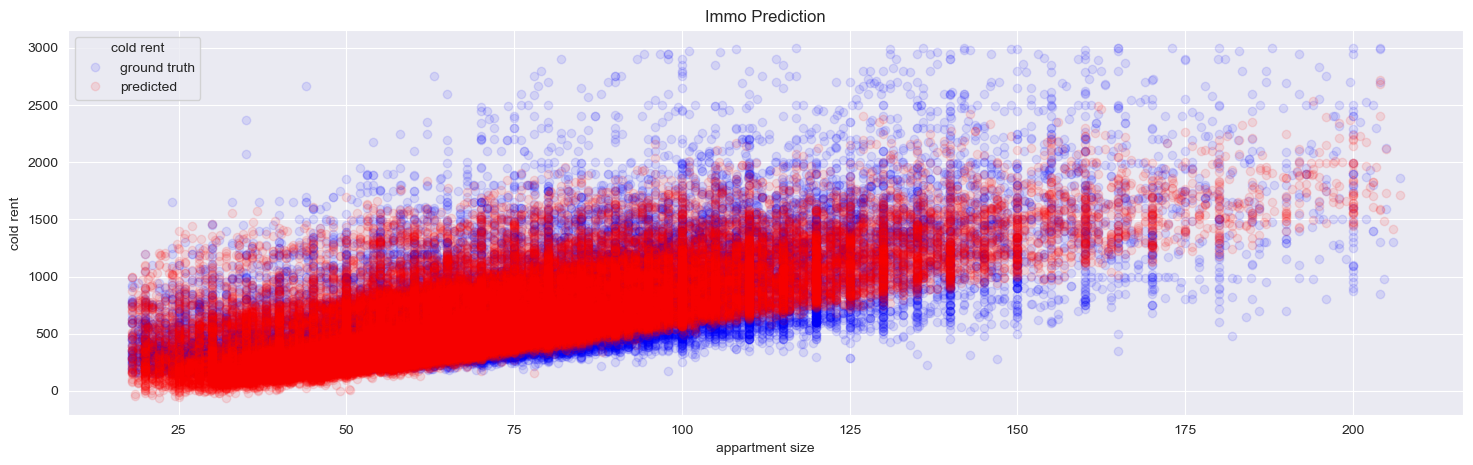

In [107]:
plt.figure(figsize=(18, 5))
plt.plot(X_test["livingSpace"], y_test, "bo", alpha=0.1, label="ground truth")
plt.plot(X_test["livingSpace"], y_test_pred, "ro", alpha=0.1, label="predicted")
plt.gca().update(dict(title="Immo Prediction", xlabel="appartment size", ylabel="cold rent"))
plt.legend(title="cold rent")
plt.show()

We can see that they roughly overlap, however the points are far from matching perfectly.

## 11: ✏️ Linear Regression Excercises
1. Copy and adapt the code from above: How does the prediction quality change when outliers are not removed?

In [109]:
immo_p2 = drop_columns(immo)
immo_p2 = remove_rows_with_NaN_target(immo_p2)
immo_p2 = impute_NaNs(immo_p2)
immo_p2 = pd.get_dummies(immo_p2)
immo_p2_Y = immo_p2.pop("baseRent")

# splitting data
X2_train, X2_test, y2_train, y2_test = train_test_split(
    immo_p2, immo_p2_Y, test_size=0.2, random_state=42
)

model_lr = linear_model.LinearRegression()
model_lr.fit(X2_train, y2_train)

y2_test_pred = model_lr.predict(X2_test)
y2_train_pred = model_lr.predict(X2_train)

# def print_evaluation(pipeline_or_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names):
print("Unscaled result:")
print_evaluation(model_lr, X2_train, X2_test, y2_train, y2_test,y2_train_pred, y2_test_pred, immo_p2.columns)
print("Scaled result:")
print_evaluation(pipe_lr, X_train, X_test, y_train, y_test, y_train_pred_pipe, y_test_pred_pipe, immo_p.columns)

Unscaled result:
LinearRegression() Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.02 |   469113671.29 |     334.93 |   215080 |      512
Test       -47.57 |    13238157.40 |     297.75 |    53770 |      512

Scaled result:
Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())]) Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.84 |       26995.95 |     106.81 |   208432 |      512
Test         0.84 |       26427.62 |     106.33 |    52108 |      512



2. Create a region-specific model, trained on only a certain geographical region (try it once with Baden-Württemberg and another time with just Karlsruhe)
   Which model does show an overfitting problem: the model of Baden-Württemberg or the model of Karlsruhe? 

In [124]:
# Baden-Württemberg dataset immo_p3 and the target is immo_p3_Y
immo_p3 = drop_columns(immo)
# TODO: Implement
immo_p3 = immo_p3[immo_p3['regio1'].str.contains("Baden_Württemberg")]
immo_p3 = remove_rows_with_NaN_target(immo_p3)
immo_p3 = remove_outliers(immo_p3)
immo_p3 = impute_NaNs(immo_p3)
immo_p3 = pd.get_dummies(immo_p3)
immo_p3_Y = immo_p3.pop("baseRent")

# data splitting
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(
    immo_p3, immo_p3_Y, test_size=0.2, random_state=42
)

# Model and its evaluation
## TODO: Implement
pipe_lr3 = make_pipeline(MinMaxScaler(), linear_model.LinearRegression())
pipe_lr3.fit(X_train_3, y_train_3)

y_test_pred_pipe_3 = pipe_lr3.predict(X_test_3)
y_train_pred_pipe_3 = pipe_lr3.predict(X_train_3)

# def print_evaluation(pipeline_or_model, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, feature_names):
print_evaluation(pipe_lr3, X_train_3, X_test_3, y_train_3, y_test_3, y_train_pred_pipe_3, y_test_pred_pipe_3, immo_p3.columns)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())]) Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.76 |       46763.20 |     154.92 |    12471 |      121
Test         0.75 |       46915.93 |     155.52 |     3118 |      121



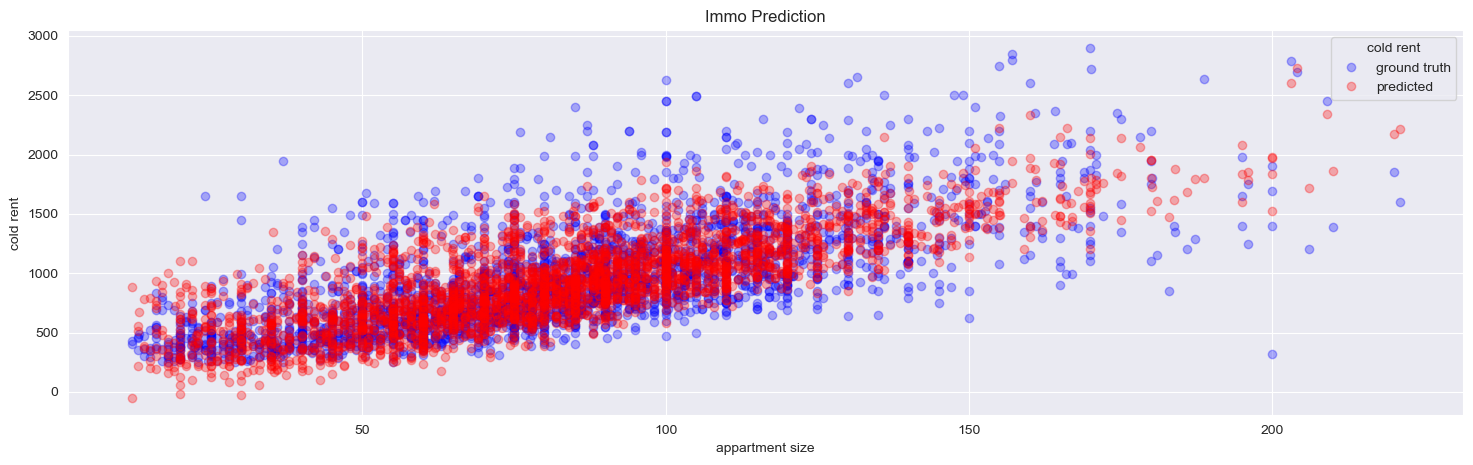

In [129]:
plt.figure(figsize=(18, 5))
plt.plot(X_test_3["livingSpace"], y_test_3, "bo", alpha=0.3, label="ground truth")
plt.plot(X_test_3["livingSpace"], y_test_pred_pipe_3, "ro", alpha=0.3, label="predicted")
plt.gca().update(dict(title="Immo Prediction", xlabel="appartment size", ylabel="cold rent"))
plt.legend(title="cold rent")
plt.show()

In [125]:
# Karlsruhe dataset immp_p4 and the target is immo_p4_Y
immo_karlsruhe = immo[immo['geo_krs'].str.contains("Karlsruhe")]
immo_p4 = drop_columns(immo_karlsruhe)
# TODO: Implement
immo_p4 = remove_rows_with_NaN_target(immo_p4)
immo_p4 = remove_outliers(immo_p4)
immo_p4 = impute_NaNs(immo_p4)
immo_p4 = pd.get_dummies(immo_p4)
immo_p4_Y = immo_p4.pop("baseRent")

# data splitting
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(
    immo_p4, immo_p4_Y, test_size=0.2, random_state=42
)

# Model and its evaluation
## TODO: Implement
pipe_lr = make_pipeline(MinMaxScaler(), linear_model.LinearRegression())
pipe_lr.fit(X_train_4, y_train_4)

y_test_pred_pipe_4 = pipe_lr.predict(X_test_4)
y_train_pred_pipe_4 = pipe_lr.predict(X_train_4)

print_evaluation(pipe_lr, X_train_4, X_test_4, y_train_4, y_test_4,y_train_pred_pipe_4, y_test_pred_pipe_4, immo_p4.columns)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())]) Evaluation:
               R² |            MSE |        MAE |     rows |  columns
Train        0.82 |       19779.26 |     103.99 |      768 |       79
Test         0.77 |       28674.57 |     129.38 |      193 |       79



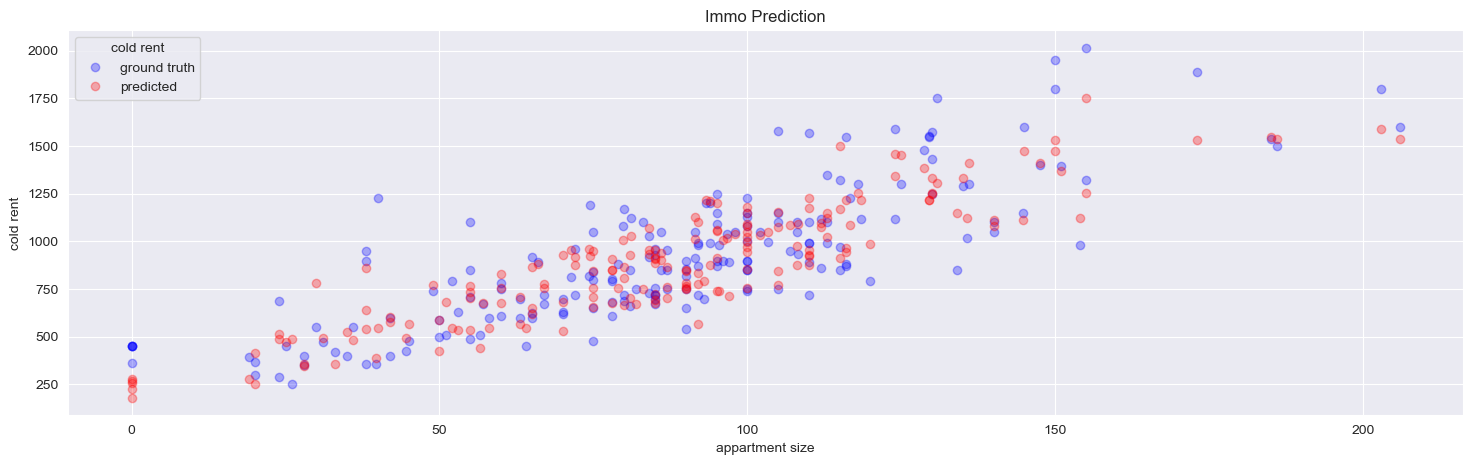

In [128]:
plt.figure(figsize=(18, 5))
plt.plot(X_test_4["livingSpace"], y_test_4, "bo", alpha=0.3, label="ground truth")
plt.plot(X_test_4["livingSpace"], y_test_pred_pipe_4, "ro", alpha=0.3, label="predicted")
plt.gca().update(dict(title="Immo Prediction", xlabel="appartment size", ylabel="cold rent"))
plt.legend(title="cold rent")
plt.show()

3. Predict the cold rent for your own appartment. Think about how the feature vector would look like for your appartment, create a DataFrame with one row and apply the best performing of the previously learned models using ``.predict()``. Take a look at ``column_descriptions`` if you are unsure of what a certain column means. 💡 This excercise is not as easy as it sounds, as you need to perform the preprocessing steps while making sure NaN values are correctly filled and one-hot-encoding works as intended to get exactly the same DataFrame structure used during fitting the model!


In [ ]:
# TODO: Implement


## 12: Regularization 

**Regularization** in ML is a term that describes methods to simplify a regression problem and **reduce the generalization error** (error on test data, not training data). It can be separated into two kinds:

- In **Explicit regularization** one explicitly adds a bias (penalty/regularization) term to the optimization problem.
    - Ridge Regression (L2 regularization): the cost function is altered by adding the _Ridge Regression penalty_ bias term (squared magnitude of the coefficient) to it.
    - Lasso Regression (L1 regularization): "Least Absolute and Selection Operator": similar to the Ridge Regression except that the penalty term contains only the **absolute** weights instead of a square of weights
        - Since it takes absolute values, hence, it can shrink the slope to 0, whereas Ridge Regression can only shrink it near 0.
- **Implicit regularization** is all other forms of regularization. This includes, for example, early stopping, using a robust loss function, and discarding outliers. Implicit regularization is essentially ubiquitous in modern machine learning approaches, including stochastic gradient descent for training deep neural networks, and ensemble methods (such as random forests and gradient boosted trees).

In this chapter we utilize the L1 & L2 regularization.

### 12.1: ✏️ Regression with Regularization
Using the L1 and L2 regularization is simple when using Scikit-Learn. 

1. Read [the documentation](https://scikit-learn.org/stable/modules/linear_model.html) to find the right methods for L1 and L2 regularization. Train both models on the geographical region from task 11.2 that showed an overfitting problem (Baden-Württemberg "immo_p3" or Karlsruhe "immo_p4") and print the evaluation. 

In [ ]:
# TODO: Implement


2. Both methods accept a parameter ``alpha``. What can this parameter be used for? Apply the same code from the previous excercise for another alpha value.

In [ ]:
# TODO: Answer and Implement


### 12.3: Hyperparameter Optimization
It now has become apparent that the parameter ``alpha`` can influence the quality of our L1 and L2 models.
However, this is just one example. Almost every ML model can be parameterized and finding the best parameters is a challenging task.

Systematic approaches to finding ideal parameters are called [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization).
They are based on the idea of systematically trying out different values for each parameters and evaluating which of them work best. 

A traditional but still popular hyperparameter optimization approach is called **grid search**, which is also provided as a [scikit-learn module](https://scikit-learn.org/stable/modules/grid_search.html).



In [ ]:
# The used dataset here is immo_p4 you can try another dataset 

grid_clf = GridSearchCV(
    linear_model.Ridge(),
    {"alpha": [1e-3, 1e-2, 1e-1, 1, 10, 100]},
    n_jobs=-1,
    return_train_score=True,
    verbose=5,
)

pipe_grid = make_pipeline(MinMaxScaler(), grid_clf)
pipe_grid.fit(X_train_4, y_train_4)

The results of this optimization can be accessed as an attribute of the gridsearch object. 
We quickly convert the returned dictionary to a Pandas DataFrame for easier reading.

In [ ]:
pd.DataFrame(grid_clf.cv_results_).set_index("params").sort_values("mean_test_score", ascending=False)


Further use of the pipeline object will automatically use the best estimator, which is refitted with the best found parameters on the whole training dataset.

In [ ]:
y_test_pred_grid = pipe_grid.predict(X_test_4)
y_train_pred_grid = pipe_grid.predict(X_train_4)

print_evaluation(
    pipe_grid,
    X_train_4,
    X_test_4,
    y_train_4,
    y_test_4,
    y_train_pred_grid,
    y_test_pred_grid,
    immo_p4.columns,
)


### 12.4: K-Fold Cross-Validation
If you paid close attention to the GridSearch documentation or the returned result table, you might have already seen that the hyperparameter optimizer uses a technique called **K-Fold Cross-Validation**, whose basic idea is as follows: 

1. The total dataset $T$ is randomly divided into $k$ equally sized subsets (splits/folds) $T_1 \dots T_k$.
2. For each iteration $i_1 \dots i_k$ a different subset $T_i$ is used as the test dataset and the remaining data $(T \setminus T_i)$ is used as the training dataset.
3. The mean value of the accuracies of the individual iterations is used as the overall result of the cross-validation.

This way, no explicit splitting of training and testing set is necessary, instead, a variety of splits will be automatically done and evaluated.
This has the advantage that meaningless accuracies of bad splits (e.g. when a certain class is only represented in test split but never in the training split) are averaged out and the mean_accuracy is more representative for the full dataset (and not just the current split).

In theory, we can run cross-validation on the full dataset (``immo_1``) and not just on the training split we defined earlier (``X_train`` and ``y_train``), however we would then have no more data to predict (or do a final evaluation on, independendent of all regularization techniques etc.). Depending on your task, you might also not have access to the test set labels but instead can only submit your predictions to a third party that can calculate you a score for it (Common for data-science challenges like on [Kaggle](https://www.kaggle.com/) or the [Data-Mining-Cup](https://www.data-mining-cup.com/)).

In the previous example using GridSearch, a 5-fold cross-validation has automatically been used for each value of alpha. Scikit-Learn provides integrated models as well, e.g. [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

Of course, it is also possible to manually call the helper methods for cross-valdiation, and a simple grid search can also be done manually:

In [ ]:
# The used dataset here is immo_p4 you can try another dataset 

results_kfcv = {}

# Loop all alphas we want to try
for alpha in [1e-3, 1e-2, 1e-1, 1, 10, 100]:
    scores = []
    # Loop over 5 different Train/Test-Splits
    splits = KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_4)
    for train_index, test_index in splits:
        scores.append(
            make_pipeline(MinMaxScaler(), linear_model.Ridge(alpha=alpha))
            .fit(X_train.iloc[train_index], y_train.iloc[train_index])
            .score(X_train.iloc[test_index], y_train.iloc[test_index])
        )
    # Save mean and standard deviation over the k=5 runs for every alpha
    results_kfcv[alpha] = {
        # "scores": scores,
        "mean_score": np.mean(scores),
        "stddev_score": np.std(scores),
    }

pd.DataFrame(results_kfcv).T.sort_values("mean_score", ascending=False)

The best performing alpha can again be easily retreived from these results. It can then be used as a parameter for training a new scikit-learn model with the whole training dataset.

### 12.5: ✏️ Advanced Regression Exercise:
1. Evaluate which out of three alpha values that you define work best when fitting a _Lasso_ regression model on the geographical region from task 11.2 that showed an overfitting problem (Baden-Württemberg "immo_p3" or Karlsruhe "immo_p4") using a 3-Fold Cross-Validation

In [ ]:
# TODO: Implement

